# Sink-source connectivity for decoding neural correlates of behavior

Applying the sink-source connectivity biomarker for analyzing neural correlates of behavior

In [326]:
import h5py 
import mat73
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import mne
import re

## Load Data

In [327]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
subs = ['07']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        # 'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        # 'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
    }

In [328]:
raw_file = h5py.File(file_paths[subs[0]]['raw_path'])
setup_data = mat73.loadmat(file_paths[subs[0]]['setup_path'])

In [329]:
elec_names = np.array(setup_data['elec_name'])
elec_areas = np.array(setup_data['elec_area'])

In [330]:
filtered_elec_areas_idxs = [i for i,ea in enumerate(elec_areas) if ea not in 
                            ['white matter','CZ','PZ', 'out','FZ','cerebrospinal fluid',
                                'lesion L','ventricle L','ventricle R']]
filtered_elec_areas = np.asarray([elec_areas[i] for i in filtered_elec_areas_idxs])
filtered_elec_names = np.asarray([elec_names[i] for i in filtered_elec_areas_idxs])
filtered_num_channels = len(filtered_elec_areas_idxs)

# Data preprocessing

In [331]:
Fs = raw_file['Fs'][0][0]
lfp_data = raw_file['lfpdata']
lfp_all = lfp_data[:,:]

# Filter Data Bandpass .5-200 Hz 
filt = mne.filter.filter_data(lfp_all,Fs,0.5,200,method="iir")
# notch filter 60 hz harmonics
for notchfreq in [60,120,180]:
    filt = mne.filter.notch_filter(filt,Fs,notchfreq, method="iir")
# decimate to 500 Hz 
decFactor = int(Fs/500)
filt = filt[:,::decFactor]

## For each channel in elec_names, get its index position in array, whether its on the end of the electrode shaft, and its neighboring indices 
lap_ref_data = np.zeros(filt.shape)
for i,en in enumerate(elec_names):
    if en in ["REF1","REF2","E","CZ","FZ","PZ"]:
        lap_ref_data[i,:] = filt[i,:]
        continue
    pattern = r"([a-z']+) *(\d+)"
    shaft_name = re.findall(pattern,en,re.IGNORECASE)[0][0]
    elec_num = re.findall(pattern,en,re.IGNORECASE)[0][1]
    en_plus1 = f"{shaft_name}{str(int(elec_num)+1)}"
    en_minus1 = f"{shaft_name}{str(int(elec_num)-1)}"
    if en_minus1 not in elec_names:
        neighbor_inds=[i-1]
    elif en_plus1 not in elec_names:
        neighbor_inds=[i+1]
    else:
        neighbor_inds = [ i-1,i+1]
    print(en, i, neighbor_inds,[elec_names[n] for n in neighbor_inds])
    neighbor_mean = np.mean(filt[neighbor_inds,:],axis=0)
    lap_ref_data[i,:] = filt[i,:] - neighbor_mean

Setting up band-pass filter from 0.5 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 200.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.35, 60.65 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 119.20, 120.80 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.8e+02 - 1.8e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-ca

In [332]:
dsFs = 500 #downsample FS is 500 Hz 
good_trials = setup_data['filters']['trial'][setup_data['filters']['success']].astype(int)-1
num_trials = len(good_trials)
win_length = 3
snapshot_data = np.zeros((num_trials,lap_ref_data.shape[0],int(win_length*dsFs)))
onset_delay = 3.0

# Snapshot around movement onset (-3 sec to 0 sec)
for i,t in enumerate(good_trials):
    start_move_time = setup_data['trial_times'][t][0][setup_data['trial_words'][t][0]==35][0]
    
    ## To go from the time to the index position in the lfp array, multiply time by Fs 
    start_move_index = int(start_move_time*dsFs)
    start_index = int((start_move_time - onset_delay)*dsFs)
    end_index = start_index+int(win_length*dsFs)
    data_slice = lap_ref_data[:,start_index:end_index]
    snapshot_data[i,:,:] = data_slice

In [333]:
unfiltered_bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(unfiltered_bets) == False)[0] # extract indices of trials without the 'nan'

bets = unfiltered_bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

data = snapshot_data[:,filtered_elec_areas_idxs,:]
y = np.asarray([(0 if bet == 5 else 1) for bet in bets])

In [334]:
high_bet_trials = np.where(y == 1)[0]
low_bet_trials = np.where(y == 0)[0]

# Compute A Matrices

In [335]:
def estimateA(X):
    # Jeff Craley's Method using definition of least squares
    Y = X[:, 1:]
    Z = X[:, 0:-1]
    A_hat = Y @ np.linalg.pinv(Z)
    return A_hat

def estimateA_subject(data, fs=500, winsize=0.2):
    window = int(np.floor(winsize * fs))
    time = data.shape[1]
    n_chs = data.shape[0]
    n_wins = int(np.round(time / window))
    A_hat = np.zeros((n_chs, n_chs, n_wins))
    for win in range(0,n_wins):
        if win*window < data.shape[1]:
            data_win = data[:,win*window:(win+1)*window]
            A_hat[:,:,win] = estimateA(data_win)
            if win % 1000 == 0:
                print(f"{win}/{n_wins} is computed")
    return A_hat

In [336]:
A_hat_all = []

for i in range(data.shape[0]):
    A_hat_all.append(estimateA_subject(data[i,:,:]))

A_hat_all = np.asarray(A_hat_all)

0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is computed
0/15 is comput

In [337]:
window_length = data.shape[2]/dsFs
num_timesteps = A_hat_all.shape[3]
time = np.linspace(0,window_length,num_timesteps) - onset_delay
time = [round(i, 2) for i in time]

# Compute Sink Indices

## Define sink index function

In [338]:
def identifySS(A):
    nCh = A.shape[0]

    A_abs = np.abs(A)
    A_abs[np.diag_indices_from(A)] = 0# set diagonals to zero

    # Compute row and column sums
    sum_A_r = np.sum(A_abs,axis=1)
    sum_A_c = np.sum(A_abs,axis=0)
    # print(sum_A_r)

    # Identify sources/sinks
    # Rank the channels from lowest (rank 1) to highest (rank nCh) based on row sum. Rank the channels from highest (rank 1) to
    # lowest (rank nCh) based on column sum. Sum the two ranks. Sinks = high rank sum and sources = low rank sum
    sort_ch_r = np.argsort(sum_A_r) # ascending
    row_ranks = np.argsort(sort_ch_r)  # rearrange the sorted channels back to being from 1:nCh
    # print(sort_ch_r)
    # print(row_ranks)
    row_ranks = row_ranks / nCh

    sort_ch_c = np.argsort(sum_A_c)[::-1] # descending
    col_ranks = np.argsort(sort_ch_c)   # rearrange the sorted channels back to being from 1:nCh
    col_ranks = col_ranks / nCh

    SI = np.sqrt(2) - np.sqrt((1-row_ranks)**2+(1-col_ranks)**2)

    return SI, row_ranks, col_ranks

## Compute sink indices

In [339]:
# Define variables
fs = 500
winSize_sec = 0.2
nWin = A_hat_all.shape[3]
nCh = A_hat_all.shape[1]
sink_row = 1
sink_col = 1
winSize = winSize_sec*fs

A_win_all_trials = []
SI_wins_all_trials = []
row_ranks_all_trials = []
col_ranks_all_trials = []

for A_hat in A_hat_all:
    SI_wins = np.zeros((nCh, nWin))
    row_ranks = np.zeros((nCh, nWin))
    col_ranks = np.zeros((nCh, nWin))
    
    for iW in range(0,nWin):
        A_win = A_hat[:,:,iW]
        SI_wins[:, iW], row_ranks[:, iW], col_ranks[:, iW] = identifySS(A_win)

    A_win_all_trials.append(A_win)
    SI_wins_all_trials.append(SI_wins)
    row_ranks_all_trials.append(row_ranks)
    col_ranks_all_trials.append(col_ranks)

In [340]:
A_win_all_trials = np.asarray(A_win_all_trials)
SI_wins_all_trials = np.asarray(SI_wins_all_trials)
row_ranks_all_trials = np.asarray(row_ranks_all_trials)
col_ranks_all_trials = np.asarray(col_ranks_all_trials)

In [341]:
SI_wins_high_bet = SI_wins_all_trials[high_bet_trials,:,:]
SI_wins_low_bet = SI_wins_all_trials[low_bet_trials,:,:]

SI_wins_difference = SI_wins_high_bet.mean(0) - SI_wins_low_bet.mean(0)

In [342]:
filtered_elec_names[np.argsort(SI_wins_difference.mean(-1))[::-1]]

array(['Q10', 'Q9', 'F3', 'F6', 'X2', 'D8', 'F5', 'X7', 'W1', 'D7', 'D5',
       'F2', 'F9', 'D9', 'Q8', 'W2', 'X10', 'D10', 'F4', 'F7', 'R1', 'W7',
       'X3', 'W9', 'R2', 'R7', 'C4', 'W8', 'Y6', 'U5', 'U4', 'C1', 'F8',
       'D6', 'Q1', 'O3', 'S9', 'R3', 'C2', 'C3', 'R4', 'W3', 'U2', 'U3',
       'Y7', 'S8', 'R6', 'S3', 'O4', 'U1', 'U7', 'Y2', 'Q2', 'U6', 'O8',
       'U9', 'O7', 'U8', 'C8', 'S1', 'S2', 'S4', 'X4', 'O2', 'O1', 'Y9',
       'Y8', 'O5', 'O6', 'Y10', 'X6', 'Y4', 'Y3', 'X5', 'C5', 'C7', 'C6'],
      dtype='<U3')

In [343]:
filtered_elec_areas[np.argsort(SI_wins_difference.mean(-1))[::-1]]

array(['middle frontal gyrus R', 'middle frontal gyrus R',
       'fusiform gyrus R', 'inferior temporal sulcus R',
       'insular cortex (anterior) R', 'middle temporal gyrus R',
       'fusiform gyrus R', 'inferior frontal gyrus (pars triangularis) R',
       'cingulate cortex (posterior) R',
       'superior temporal gyrus (planum temporale) R',
       'superior temporal gyrus (planum temporale) R', 'fusiform gyrus R',
       'inferior temporal gyrus R', 'middle temporal gyrus R',
       'middle frontal gyrus R', 'cingulate cortex (posterior) R',
       'inferior frontal sulcus R', 'middle temporal gyrus R',
       'fusiform gyrus R', 'inferior temporal gyrus R',
       'insular cortex (anterior) R', 'superior temporal sulcus R',
       'insular cortex (anterior) R',
       'superior temporal gyrus (planum temporale) R',
       'insular cortex (anterior) R',
       'inferior frontal gyrus (pars opercularis) R',
       'middle temporal gyrus R',
       'superior temporal gyrus (plan

## T-Test

In [17]:
unique_ch_areas = np.unique(filtered_elec_areas)

ch_area_idxs = []

for ch_area in unique_ch_areas:
    ch_area_idxs.append(np.where(np.isin(filtered_elec_areas, ch_area)))

In [47]:
from scipy.stats import ttest_ind

SI_wins_high_bet_all_areas = []
SI_wins_low_bet_all_areas = []

for idxs in ch_area_idxs:
    # Get the SI values for the high and low bet trials for the current area, average across time window, and flatten
    SI_wins_high_bet_area = SI_wins_high_bet.mean(axis=-1)
    SI_wins_low_bet_area = SI_wins_low_bet.mean(axis=-1)

    SI_wins_high_bet_area = SI_wins_high_bet_area[:,idxs[0]].flatten()
    SI_wins_low_bet_area = SI_wins_low_bet_area[:,idxs[0]].flatten()

    SI_wins_high_bet_all_areas.append(SI_wins_high_bet_area)
    SI_wins_low_bet_all_areas.append(SI_wins_low_bet_area)

In [49]:
t_stats = []
p_vals = []

for i in range(len(unique_ch_areas)):
    t_stat, p_val = ttest_ind(SI_wins_high_bet_all_areas[i], SI_wins_low_bet_all_areas[i], equal_var=False)
    t_stats.append(t_stat)
    p_vals.append(p_val)

Text(0.5, 1.0, 'P-Values for T-Test of SI Values for High and Low Bet Trials')

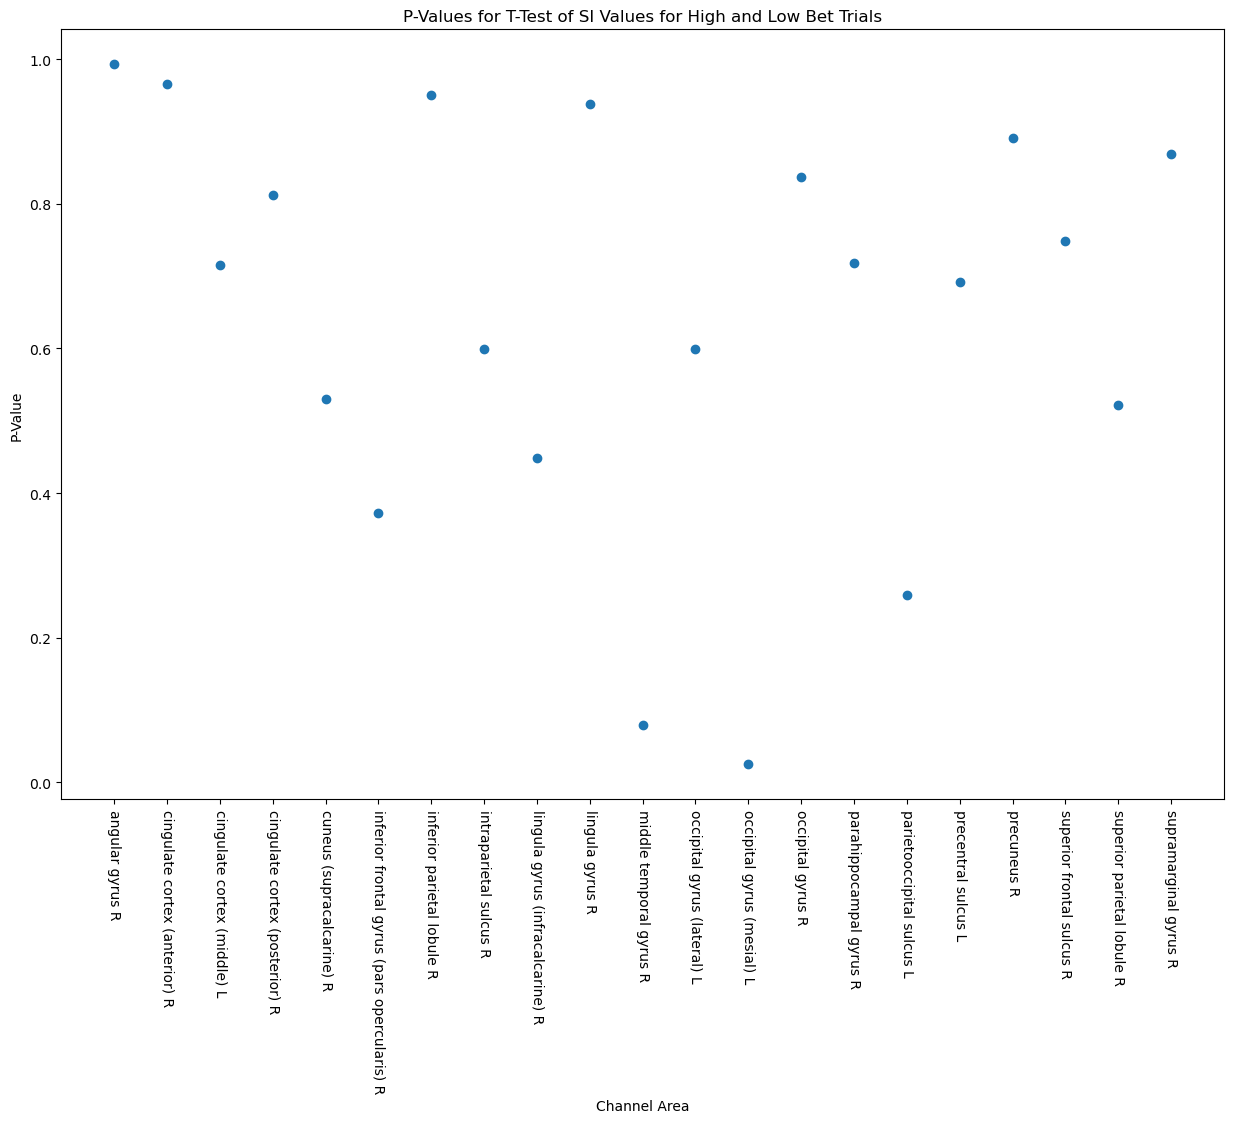

In [50]:
fig, axs = plt.subplots(1, figsize=(15,10))

axs.scatter(np.arange(len(unique_ch_areas)), p_vals)
axs.set_xticks(np.arange(len(unique_ch_areas)), labels=unique_ch_areas,rotation=-90)
axs.set_ylabel('P-Value')
axs.set_xlabel('Channel Area')
axs.set_title('P-Values for T-Test of SI Values for High and Low Bet Trials')

## LDA

In [273]:
unique_ch_areas = np.unique(filtered_elec_areas)

ch_area_idxs = []

for ch_area in unique_ch_areas:
    ch_area_idxs.append(np.where(np.isin(filtered_elec_areas, ch_area)))

In [308]:
brain_areas = ['superior temporal gyrus (planum temporale) R',
               'temporal pole R',
               'angular gyrus R',
               'entorhinal cortex R',
               'middle temporal gyrus R'
               ]

ch_idxs = []

for area in brain_areas:
    area_idxs = ch_area_idxs[np.where(unique_ch_areas == area)[0][0]] 
    ch_idxs = np.concatenate((ch_idxs, area_idxs[0])).astype(int)

In [291]:
SI_wins_all_trials_avg_elec_areas = []

for idxs in ch_area_idxs:
    SI_wins_avg_elec_areas = SI_wins_all_trials[:,idxs[0],:]
    SI_wins_all_trials_avg_elec_areas.append(SI_wins_avg_elec_areas.mean(axis=1))

SI_wins_all_trials_avg_elec_areas = np.asarray(SI_wins_all_trials_avg_elec_areas)
X = SI_wins_all_trials_avg_elec_areas.mean(-1).T

In [312]:
# X = SI_wins_all_trials[:,ch_idxs,:].mean(-1)
X = SI_wins_all_trials.mean(-1)

In [313]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression

rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=72)

estimators = []
scores = []

for train, test in rkf.split(X):
    model = LinearDiscriminantAnalysis()
    model.fit(X[train], y[train])
    estimators.append(model)
    scores.append(model.score(X[test], y[test]))

scores = np.asarray(scores)
lda_coef = estimators[scores.argmax()].coef_[0]
sort_lda_coef = np.argsort(np.abs(lda_coef))

In [314]:
scores

array([0.72727273, 0.54545455, 0.40625   , 0.53125   , 0.5625    ])

In [315]:
filtered_elec_areas[sort_lda_coef][::-1][:10]

array(['superior temporal gyrus (planum temporale) R',
       'superior temporal gyrus (planum temporale) R', 'temporal pole R',
       'angular gyrus R', 'entorhinal cortex R', 'temporal pole R',
       'middle temporal gyrus R', 'middle temporal gyrus R',
       'fusiform gyrus R', 'orbitofrontal cortex (mesial) R'],
      dtype='<U44')

In [53]:
unique_ch_areas[sort_lda_coef]

array(['cuneus (supracalcarine) R',
       'inferior frontal gyrus (pars opercularis) R',
       'superior frontal sulcus R', 'occipital gyrus (lateral) L',
       'parahippocampal gyrus R', 'middle temporal gyrus R',
       'precentral sulcus L', 'superior parietal lobule R',
       'angular gyrus R', 'cingulate cortex (anterior) R',
       'cingulate cortex (middle) L', 'lingula gyrus R',
       'cingulate cortex (posterior) R',
       'lingula gyrus (infracalcarine) R', 'inferior parietal lobule R',
       'supramarginal gyrus R', 'occipital gyrus (mesial) L',
       'parietooccipital sulcus L', 'intraparietal sulcus R',
       'occipital gyrus R', 'precuneus R'], dtype='<U43')

## Plot sink index heatmap

In [350]:
SI_overall_all = []

for A_hat in A_hat_all:
    # Computer A_mean over time wins
    A_mean = np.mean(A_hat, axis=2)
    SI_overall, _, _ = identifySS(A_mean)
    SI_overall_all.append(SI_overall)

SI_overall_all = np.asarray(SI_overall_all)

SI_overalls_low_bet = SI_overall_all[low_bet_trials,:]
SI_overalls_high_bet = SI_overall_all[high_bet_trials,:]
SI_overalls_difference = SI_overalls_high_bet.mean(axis=0) - SI_overalls_low_bet.mean(axis=0)

SI_sort_idx_overall = np.argsort(SI_overall_all.mean(0))
SI_wins_sorted = SI_wins_low_bet.mean(0)[SI_sort_idx_overall, :]
labels_sort = [filtered_elec_areas[i] + " | " + filtered_elec_names[i] for i in SI_sort_idx_overall]

In [351]:
# recording_len_sec = time_axis[-1]
t_W = np.arange(0, nWin, 1)
t_sec = np.arange(0, nWin*winSize/fs, 0.5)
# time_labs = [time_sum(rec_start_time, sec2time(t)) for t in t_sec]
# time_labs_gap = int(np.floor(recording_len_sec/20)) # 5 sec for example
t_W_fig = t_W.copy()
t_W_fig = t_W_fig[::30*2] - t_W_fig[0]
# time_labs_fig = time_labs # can be limited to fig_start_Wi:fig_end_Wi
# time_labs_fig = time_labs_fig[::30*2]

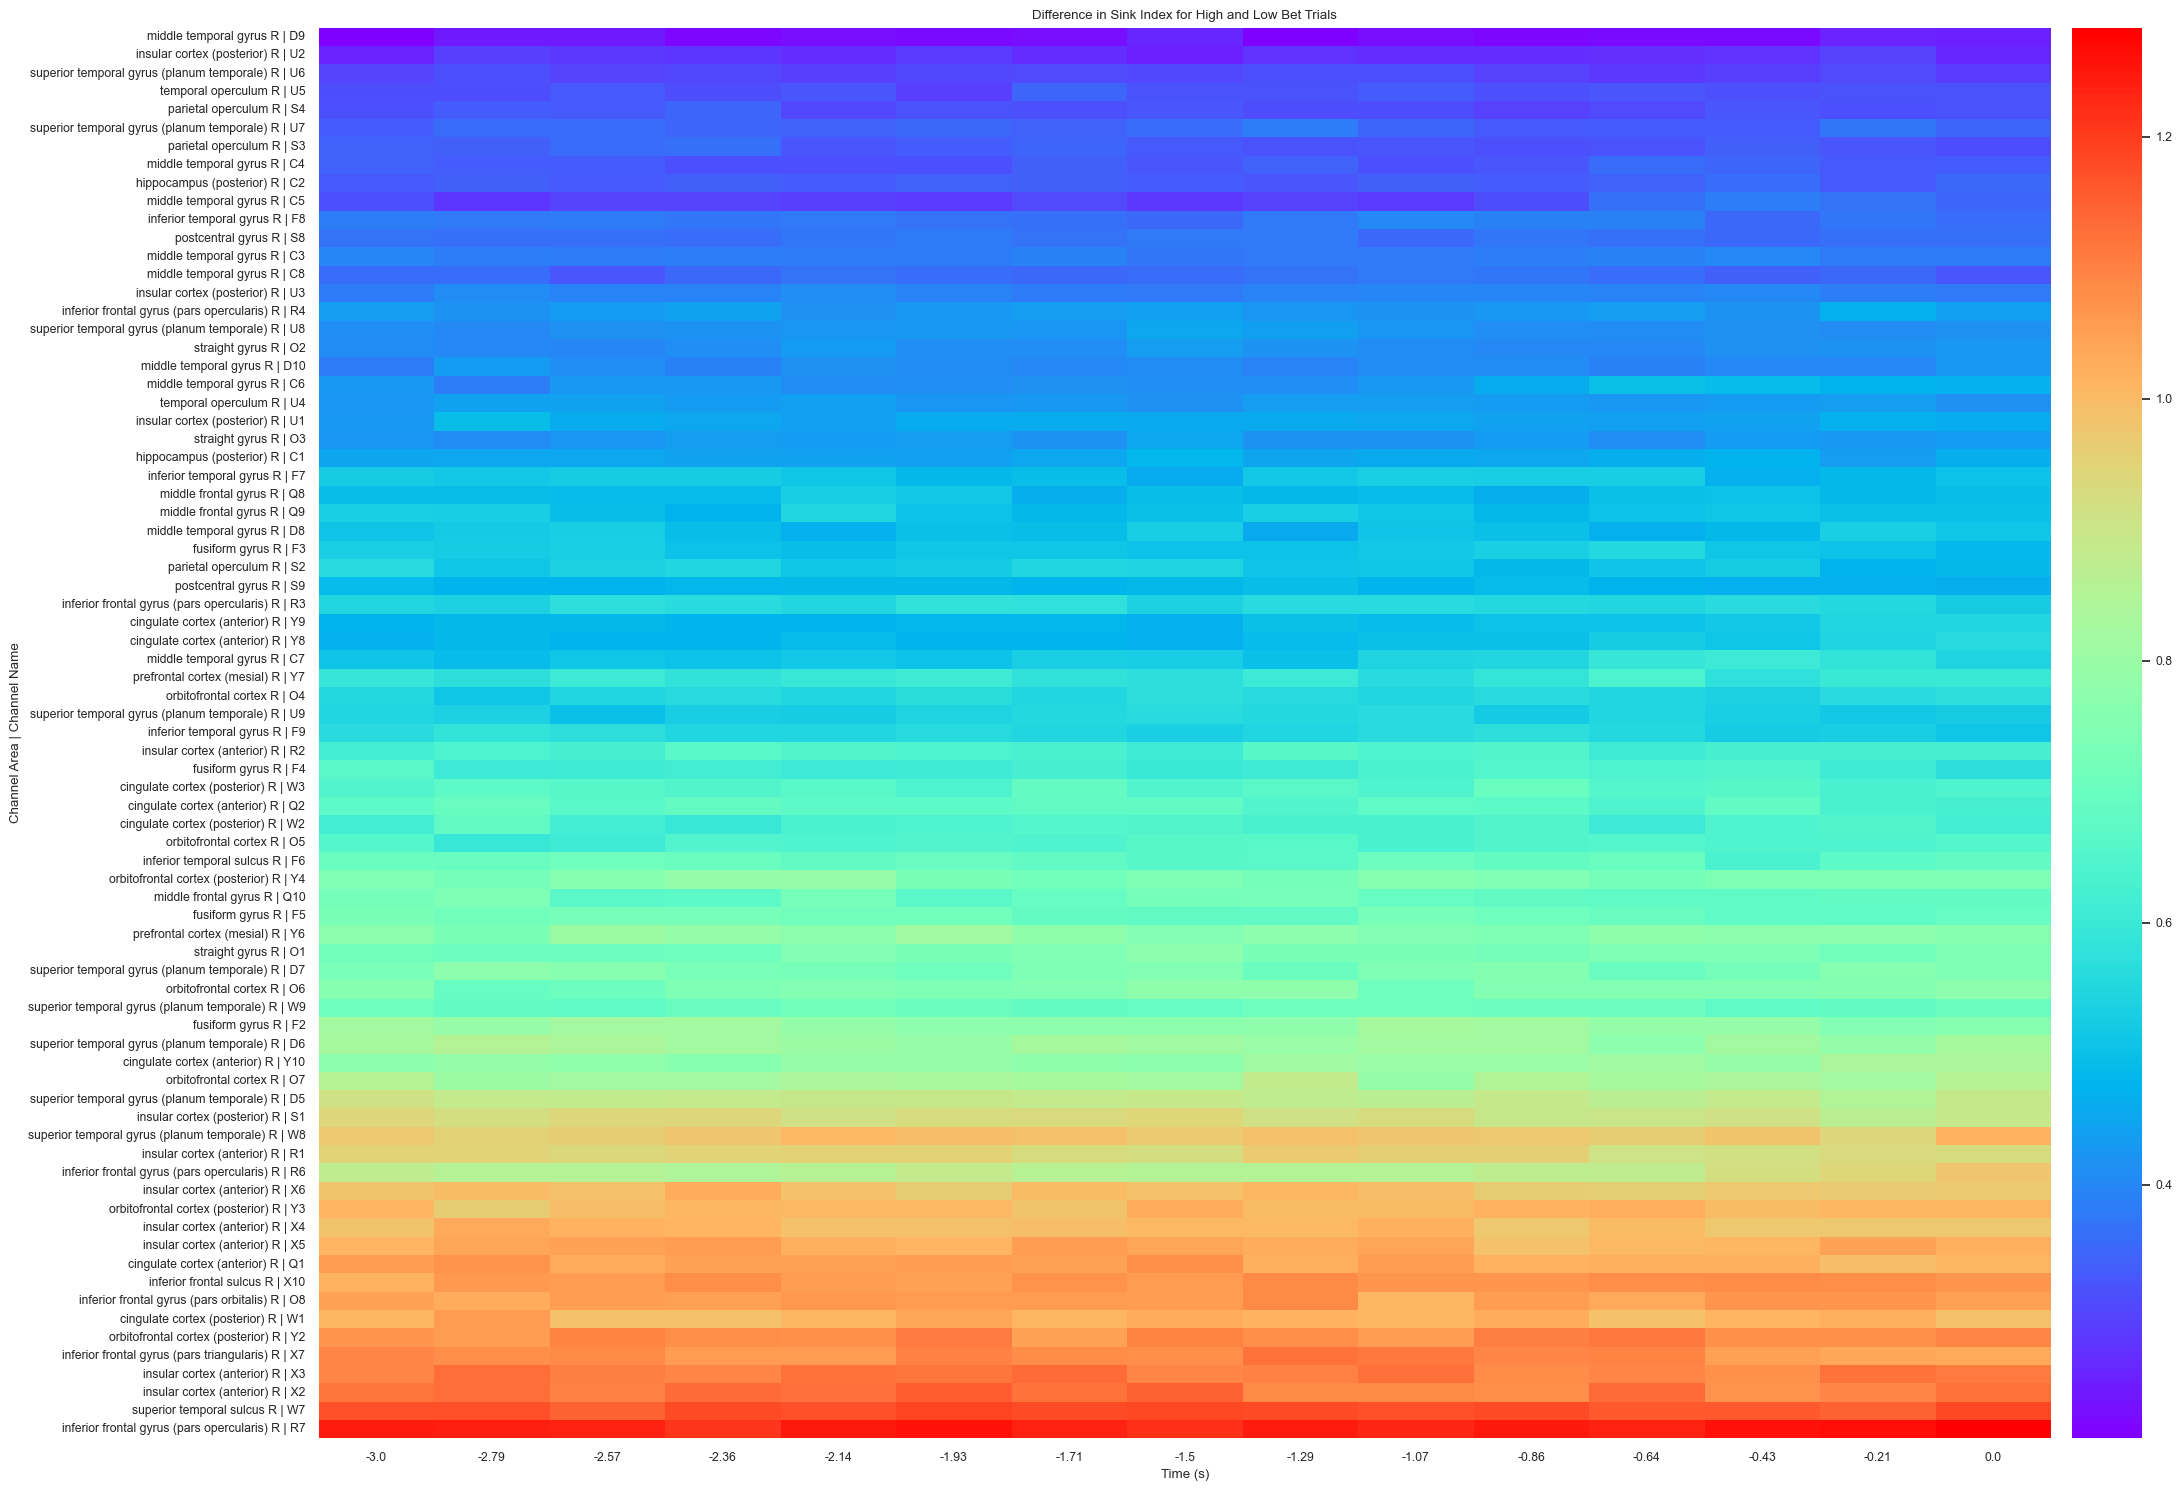

In [352]:
fig, axs = plt.subplots(1,1,figsize=(24, 15))
sns.heatmap(SI_wins_sorted, xticklabels=time, yticklabels=labels_sort,cmap=sns.color_palette("rainbow", as_cmap=True), cbar_kws={"pad": 0.01})
sns.set(font_scale=0.8)

axs.set_title('Difference in Sink Index for High and Low Bet Trials')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Channel Area | Channel Name')

# ax.set_xticks(t_W_fig)
# ax.set_xticklabels(time_labs_fig, rotation=70, fontsize=16)
# title = f'Folder {subject} - Recording {rec_label}\n' + \
#         f'Sink indices during a whole recording on {rec_start_date}\n' + \
#         f'From {rec_start_time} to {rec_stop_time}'
# ax.set_title(title, fontsize=25)
# ldg = plt.legend(fontsize=15, loc='lower right', facecolor='#fcfcfa')
plt.grid(False)
plt.tight_layout()
# if not exists(subject):
#     makedirs(subject)
# if not exists(f'{subject}\\{rec_label}'):
#     makedirs(f'{subject}\\{rec_label}')
# plt.savefig(f'{subject}\\{rec_label}\\{rec_label}-SI+heatmap.png', transparent=False, bbox_extra_artists=(ldg,), bbox_inches='tight')
plt.show()

In [133]:
np.where(y==1)

(array([  3,   7,  11,  12,  13,  14,  15,  18,  20,  21,  22,  24,  26,
         29,  31,  32,  33,  34,  39,  40,  41,  42,  46,  47,  49,  52,
         53,  55,  56,  59,  61,  62,  63,  64,  65,  67,  68,  70,  71,
         72,  74,  76,  77,  78,  82,  89,  90,  91,  93,  95,  96,  97,
         98, 100, 101, 102, 103, 104, 105, 107, 108, 111, 113, 115, 118,
        120, 122, 125, 128, 129, 130, 131, 134, 137, 138, 142, 145, 147,
        149, 151, 153, 154, 155, 159, 160, 161]),)

In [117]:
y[3]

1

# Compute spectral entropy

In [ ]:
from tqdm.auto import tqdm
from TorchSpectra import compute_spectrogram

minu = 0.05 # minutes of SItime_t to compute entropy
n = int(minu*60/winSize_sec)

varSE_all = np.zeros((nCh,nWin))

pbar = tqdm(total=nCh, desc='Percentage of entropies computed', position=0) # Daniel's suggestion
for chi in range(nCh):
    # pbar.set_postfix({'Channel': labels[chi]})

    SI_channel = SI_wins[chi,:]

    SI_channel = np.concatenate((np.zeros((n)), SI_channel))

    time_axis, frequency_axis, power_spectrogram = compute_spectrogram(input_vector=SI_channel, sample_rate=2, window_size=n, hop_size=1, n_fft=n, window_type="boxcar")

    power_spectrogram = power_spectrogram[:,:-1]

    psd = power_spectrogram[1:,:] # exclude DC
    with np.errstate(divide='ignore', invalid='ignore'):
        psd_norm = psd / psd.sum(axis=0, keepdims=True)
        psd_norm[psd_norm == np.inf] = 0
    se = -_xlogx(psd_norm).sum(axis=0) # Sum over all frequencies
    se /= np.log2(psd_norm.shape[0])

    varSE_all[chi, :] = se

    pbar.update(1) # DONE WITH COMPUTATION FOR CHANNEL {chi}
